In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from collections import Counter

from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
#from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import learning_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve


In [49]:
#Python 3.8.12 (default, Oct 12 2021, 06:23:56) 
#[Clang 10.0.0 ] :: Anaconda, Inc. on darwin

#!python - V

Python 3.8.12 (default, Oct 12 2021, 06:23:56) 
[Clang 10.0.0 ] :: Anaconda, Inc. on darwin
Type "help", "copyright", "credits" or "license" for more information.
>>> 

distributed.scheduler - INFO - Remove worker <WorkerState 'tcp://127.0.0.1:51387', name: 0, status: running, memory: 0, processing: 0>
distributed.worker - INFO - Stopping worker at tcp://127.0.0.1:51387
distributed.worker - INFO - Stopping worker at tcp://127.0.0.1:51388
distributed.worker - INFO - Stopping worker at tcp://127.0.0.1:51386
distributed.worker - INFO - Stopping worker at tcp://127.0.0.1:51395
distributed.core - INFO - Removing comms to tcp://127.0.0.1:51387
distributed.scheduler - INFO - Remove worker <WorkerState 'tcp://127.0.0.1:51388', name: 1, status: running, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://127.0.0.1:51388
distributed.scheduler - INFO - Remove worker <WorkerState 'tcp://127.0.0.1:51386', name: 3, status: running, memory: 0, processing: 0>
distributed.core - INFO - Removing comms to tcp://127.0.0.1:51386
distributed.scheduler - INFO - Remove worker <WorkerState 'tcp://127.0.0.1:51395', name: 2, status: closing, memory: 0, p


KeyboardInterrupt
>>> 
>>> 

## Dask Client Setup

In [2]:
import dask
import dask.distributed
from dask.distributed import Client, LocalCluster

from sklearn.utils import parallel_backend
import joblib

from dask.utils import format_bytes
from dask_ml.model_selection import GridSearchCV as DaskGridSearchCV

In [3]:
# dask.config.get()

In [4]:
#from dask.distributed import Client

# If you have a remote cluster running Dask
# client = Client('tcp://scheduler-address:8786')

cluster=LocalCluster(dashboard_address="localhost:9999",silence_logs=False)

# If you want Dask to set itself up on your personal computer
client = Client(cluster)

#client.dashboard_link

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:51374
distributed.scheduler - INFO -   dashboard at:            127.0.0.1:9999
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:51377'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:51378'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:51379'
distributed.nanny - INFO -         Start Nanny at: 'tcp://127.0.0.1:51380'
distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:51388
distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:51387
distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:51386
distributed.worker - INFO -          Listening to:      tcp://127.0.0.1:51388
distributed.worker - INFO -          Listening to:      tcp://127.0.0.1:51387
distributed.worker - INFO -          dashboard at:            127.0.0.1:51390
distributed.worker - INFO -          d

In [5]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:9999/status,
Dashboard: http://127.0.0.1:9999/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:51374,Workers: 4
Dashboard: http://127.0.0.1:9999/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:51387,Total threads: 2
Dashboard: http://127.0.0.1:51391/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:51379,


In [6]:
X_total = pd.read_csv('X.csv')
# X = pd.read_csv('s3://cxa-lc-data/X.csv')

y_total = pd.read_csv('y.csv')
# y = pd.read_csv('s3://cxa-lc-data/y.csv')

y_total = y_total.values.ravel()

In [7]:
sample_size = 50000

X= X_total
y= y_total

X_subsample, _, y_subsample, __ = train_test_split(X, y, train_size=sample_size, stratify=y, random_state=42)

In [8]:
print(len(X_subsample))
print(len(y_subsample))

50000
50000


In [9]:
#redefining X and y to be the 50k stratified subsample

X= X_subsample
y= y_subsample

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)

In [10]:
print(len(X_train))
print(len(y_train))

37500
37500


In [11]:
num_transform = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('norm', PowerTransformer(method='yeo-johnson', standardize=True))
])

#BOXCOX TRANSFORM
# num_transform = Pipeline(steps=[
#     ('imputer',SimpleImputer(strategy='median')),
#     ('scale', MinMaxScaler([1,2]))
#     ('norm', PowerTransformer(method='box-cox', standardize=True))])

cat_transform = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])

# CONSTANT CAT. IMPUTER
# cat_transform = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
#     ('onehot',OneHotEncoder(handle_unknown='ignore'))
# ])

In [12]:
num_ix = X.select_dtypes(['float64','int64']).columns
cat_ix = X.select_dtypes(['O']).columns

In [13]:
#Build out the column transformer

t= [
    ('categorical',cat_transform,cat_ix),
    ('numerical',num_transform,num_ix),
]

ct = ColumnTransformer(transformers=t,remainder='passthrough')

In [14]:
#Define metric used
F2 = make_scorer(fbeta_score, beta=2)
metric = F2
# metric = 'roc_auc'

In [15]:
#gridsearch class_weight: balanced, balanced_subsample

#model = BalancedRandomForestClassifier(n_estimators=10)

## Base RF

In [27]:
%%time

with parallel_backend('dask'):

    model = RandomForestClassifier()

    pipe = Pipeline(steps=[
        ('preprocess',ct),
        ('model', model)
    ])

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    
    #param_grid = {'model_tune__n_estimators': [100]}
    param_grid = {'model__max_features': ['auto']}

    grid = DaskGridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=metric) 

    grid_result = grid.fit(X_train, y_train)

    #scores = cross_val_score(grid_result, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)

print(f'Best score:{grid_result.best_score_}')
print(f'Best params:{grid_result.best_params_}')


Best score:0.9212580005648577
Best params:{'model__max_features': 'auto'}
CPU times: user 32.9 s, sys: 2.89 s, total: 35.8 s
Wall time: 1min 31s


In [26]:
# %%time

# with parallel_backend('loky'):

#     model = RandomForestClassifier()

#     pipe = Pipeline(steps=[
#         ('preprocess',ct),
#         ('model', model)
#     ])

#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

#     #param_grid = {'model_tune__n_estimators': [100]}
#     param_grid = {'model__max_features': ['auto']}

#     grid = GridSearchCV(estimator=pipe, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=metric, verbose=1) 

#     grid_result = grid.fit(X_train, y_train)

#     #scores = cross_val_score(grid_result, X_train, y_train, scoring=metric, cv=cv, n_jobs=-1)

# print(f'Best score:{grid_result.best_score_}')
# print(f'Best params:{grid_result.best_params_}')

In [28]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

0.921258 (0.008934) with: {'model__max_features': 'auto'}


In [29]:
pred = grid_result.predict(X_test)

conf_matx = confusion_matrix(y_test, pred)

print(conf_matx) 

classif_report = classification_report(y_test,pred,digits=3)

print(classif_report)

[[10852    31]
 [  139  1478]]
              precision    recall  f1-score   support

           0      0.987     0.997     0.992     10883
           1      0.979     0.914     0.946      1617

    accuracy                          0.986     12500
   macro avg      0.983     0.956     0.969     12500
weighted avg      0.986     0.986     0.986     12500



Precision: 0.9874
Recall: 0.9972
AUROC: 0.956


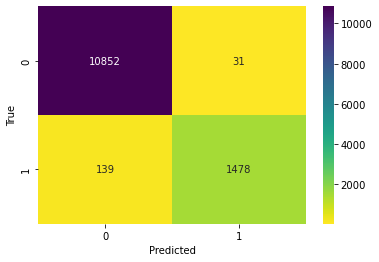

In [30]:
true_pos = conf_matx[0][0]
false_pos = conf_matx[1][0]
true_neg = conf_matx[1][1]
false_neg = conf_matx[0][1]

precision = true_pos/(true_pos + false_pos)

recall = true_pos/(true_pos + false_neg)

auroc = roc_auc_score(y_test,pred)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'AUROC: {auroc:.3f}')

ax = sns.heatmap(conf_matx, cmap='viridis_r', annot=True, fmt='d')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()


Predicting all majority class: 0.8706
Random Forest ROC AUC: 0.9556
Best F2 Score: 0.9213


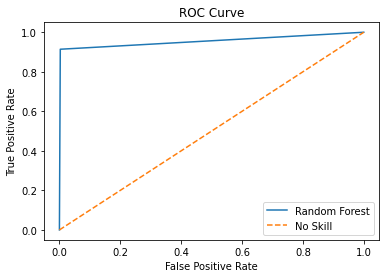

In [31]:
#Evaluating on F2 Score but just looking at area under ROC curve

print(f'Predicting all majority class: {Counter(y_test)[0]/(Counter(y_test)[0]+Counter(y_test)[1]):.4f}')

print(f'Random Forest ROC AUC: {auroc:.4f}')

print(f'Best F2 Score: {grid.best_score_:.4f}')

fpr, tpr, _ = roc_curve(y_test,pred)


plt.plot(fpr,tpr, label='Random Forest')
plt.plot([0,1],[0,1], linestyle='--', label = 'No Skill')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Tuned RF

In [49]:
# X_train_dask = dask.dataframe.from_pandas(X_train,npartitions=8)
# X_test_dask = dask.dataframe.from_pandas(X_test, npartitions=8)

# print(X_train_dask.to_dask_array())

# for name, X in [("train", X_train_dask.to_dask_array()), ("test", X_test_dask.to_dask_array())]:
#     print("dataset =", name)
#     print("shape =", X.shape)
#     print("bytes =", format_bytes(X.nbytes))
#     print("-" * 20)

In [21]:
%%time

#DASK

#SKlearn Gridsearch takes 13mins
#DaskGSCV takes 5min 11 seconds without a local cluster (1 worker); similar time with local cluster (4 workers)

with parallel_backend('dask'):

    model_tune = RandomForestClassifier()

    pipe_tune = Pipeline(steps=[
        ('preprocess',ct),
        ('model_tune', model_tune)
    ])

    cv_tune = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

    param_grid_tune = [
        {'model_tune__class_weight': ['balanced','balanced_subsample'],
         'model_tune__n_estimators': [50,100,250],
         'model_tune__max_depthint' : [4,8, None],
         'model_tune__max_features': ['sqrt',None]}
         ]

    grid_tune = DaskGridSearchCV(estimator=pipe_tune, param_grid=param_grid_tune, n_jobs=-1, cv=cv_tune, scoring=metric) 

    grid_result_tune = grid_tune.fit(X_train, y_train)

    #scores_tune = cross_val_score(grid_result_tune, X_test, y_test, scoring=metric, cv=cv_tune, n_jobs=-1)

print(f'Best score:{grid_result_tune.best_score_}')
print(f'Best params:{grid_result_tune.best_params_}')


Best score:0.9577331011924352
Best params:{'model_tune__class_weight': 'balanced_subsample', 'model_tune__max_features': None, 'model_tune__n_estimators': 250}
CPU times: user 28min 5s, sys: 2min 20s, total: 30min 26s
Wall time: 1h 15min 24s


In [ ]:
# print(f'Best score:{grid_result_tune.best_score_}')
# print(f'Best params:{grid_result_tune.best_params_}')

In [37]:
# %%time

# #THREADS
##Takes Wall time: 8min 32s

# with parallel_backend('threading'):

#     model_tune = RandomForestClassifier()

#     pipe_tune = Pipeline(steps=[
#         ('preprocess',ct),
#         ('model_tune', model_tune)
#     ])

#     cv_tune = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

#     param_grid_tune = [
#         {'model_tune__class_weight': ['balanced','balanced_subsample'],
#          'model_tune__n_estimators': [50,100,250],
#          'model_tune__max_features': ['sqrt',None]}
#          ]

#     grid_tune = GridSearchCV(estimator=pipe_tune, param_grid=param_grid_tune, n_jobs=-1, cv=cv_tune, scoring=metric, verbose=1) 

#     grid_result_tune = grid_tune.fit(X_train, y_train)

#     #scores_tune = cross_val_score(grid_result_tune, X_test, y_test, scoring=metric, cv=cv_tune, n_jobs=-1)

#     print(f'Best score:{grid_result_tune.best_score_}')
#     print(f'Best params:{grid_result_tune.best_params_}')


In [38]:
# %%time

# #THREADS ONLY ON THE FIT

# #Wall time: 8min 32s for threads 


# #Wall time: 8min 32s 

# model_tune = RandomForestClassifier()

# pipe_tune = Pipeline(steps=[
#     ('preprocess',ct),
#     ('model_tune', model_tune)
# ])

# cv_tune = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# param_grid_tune = [
#     {'model_tune__class_weight': ['balanced','balanced_subsample'],
#      'model_tune__n_estimators': [50,100,250],
#      'model_tune__max_features': ['sqrt',None]}
#      ]

# grid_tune = GridSearchCV(estimator=pipe_tune, param_grid=param_grid_tune, n_jobs=-1, cv=cv_tune, scoring=metric, verbose=1) 

# with parallel_backend('threading'):
    
#     grid_result_tune = grid_tune.fit(X_train, y_train)

# #scores_tune = cross_val_score(grid_result_tune, X_test, y_test, scoring=metric, cv=cv_tune, n_jobs=-1)

# print(f'Best score:{grid_result_tune.best_score_}')
# print(f'Best params:{grid_result_tune.best_params_}')


In [39]:
# %%time

# #DEFAULT parallel backend (loky)

# model_tune = RandomForestClassifier()

# pipe_tune = Pipeline(steps=[
#     ('preprocess',ct),
#     ('model_tune', model_tune)
# ])

# cv_tune = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

# param_grid_tune = [
#     {'model_tune__class_weight': ['balanced','balanced_subsample'],
#      'model_tune__n_estimators': [50,100,250],
#      'model_tune__max_features': ['sqrt', None]}
#      ]

# grid_tune = GridSearchCV(estimator=pipe_tune, param_grid=param_grid_tune, n_jobs=-1, cv=cv_tune, scoring=metric, verbose=1) 

# grid_result_tune = grid_tune.fit(X_train, y_train)

# #scores_tune = cross_val_score(grid_result_tune, X_test, y_test, scoring=metric, cv=cv_tune, n_jobs=-1)

# print(f'Best score:{grid_result_tune.best_score_}')
# print(f'Best params:{grid_result_tune.best_params_}')


In [22]:
means_tune = grid_result_tune.cv_results_['mean_test_score']
stds_tune = grid_result_tune.cv_results_['std_test_score']
params_tune = grid_result_tune.cv_results_['params']
for mean, stdev, param in zip(means_tune, stds_tune, params_tune):
    print('%f (%f) with: %r' % (mean, stdev, param))

0.906125 (0.011213) with: {'model_tune__class_weight': 'balanced', 'model_tune__max_features': 'sqrt', 'model_tune__n_estimators': 50}
0.910325 (0.013837) with: {'model_tune__class_weight': 'balanced', 'model_tune__max_features': 'sqrt', 'model_tune__n_estimators': 100}
0.913822 (0.011089) with: {'model_tune__class_weight': 'balanced', 'model_tune__max_features': 'sqrt', 'model_tune__n_estimators': 250}
0.956073 (0.007327) with: {'model_tune__class_weight': 'balanced', 'model_tune__max_features': None, 'model_tune__n_estimators': 50}
0.957350 (0.008447) with: {'model_tune__class_weight': 'balanced', 'model_tune__max_features': None, 'model_tune__n_estimators': 100}
0.957674 (0.007790) with: {'model_tune__class_weight': 'balanced', 'model_tune__max_features': None, 'model_tune__n_estimators': 250}
0.908125 (0.010511) with: {'model_tune__class_weight': 'balanced_subsample', 'model_tune__max_features': 'sqrt', 'model_tune__n_estimators': 50}
0.911190 (0.010754) with: {'model_tune__class_w

In [23]:
pred_tune = grid_result_tune.predict(X_test)

conf_matx_tune = confusion_matrix(y_test, pred_tune)

print(conf_matx_tune) 

classif_report_tune = classification_report(y_test,pred_tune,digits=3)

print(classif_report_tune)

[[10867    16]
 [   85  1532]]
              precision    recall  f1-score   support

           0      0.992     0.999     0.995     10883
           1      0.990     0.947     0.968      1617

    accuracy                          0.992     12500
   macro avg      0.991     0.973     0.982     12500
weighted avg      0.992     0.992     0.992     12500



Precision: 0.9922
Recall: 0.9985
AUROC: 0.973


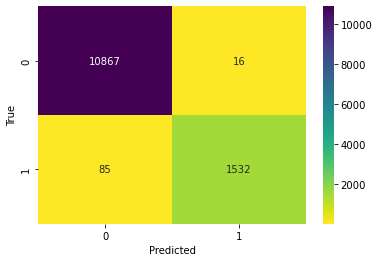

In [24]:
true_pos_tune = conf_matx_tune[0][0]
false_pos_tune = conf_matx_tune[1][0]
true_neg_tune = conf_matx_tune[1][1]
false_neg_tune = conf_matx_tune[0][1]

precision_tune = true_pos_tune/(true_pos_tune + false_pos_tune)

recall_tune = true_pos_tune/(true_pos_tune + false_neg_tune)

auroc_tune = roc_auc_score(y_test,pred_tune)

print(f'Precision: {precision_tune:.4f}')
print(f'Recall: {recall_tune:.4f}')
print(f'AUROC: {auroc_tune:.3f}')

ax_tune = sns.heatmap(conf_matx_tune, cmap='viridis_r', annot=True, fmt='d')
ax_tune.set_xlabel('Predicted')
ax_tune.set_ylabel('True')
plt.show()


Predicting all majority class: 0.8706
Random Forest ROC AUC: 0.9730
Best F2 Score: 0.9577


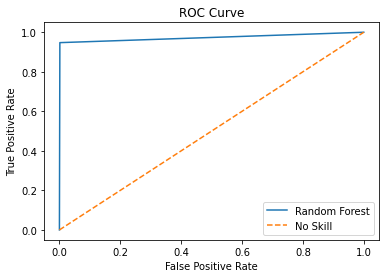

In [25]:
#Evaluating on F2 Score but just looking at area under ROC curve

print(f'Predicting all majority class: {Counter(y_test)[0]/(Counter(y_test)[0]+Counter(y_test)[1]):.4f}')

print(f'Random Forest ROC AUC: {auroc_tune:.4f}')

print(f'Best F2 Score: {grid_tune.best_score_:.4f}')

fpr_tune, tpr_tune, _ = roc_curve(y_test,pred_tune)

plt.plot(fpr_tune,tpr_tune, label='Random Forest')
plt.plot([0,1],[0,1], linestyle='--', label = 'No Skill')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Learning Curves

In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [ ]:

fig, axes = plt.subplots(3, 2, figsize=(10, 15))

title = "Learning Curves (Random Forest)"

cv_learn = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

estimator = grid_result_tune
#estimator = grid_result_tune.best_estimator_

plot_learning_curve(
    estimator, title, X_train, y_train, axes=axes[:, 0], ylim=(0.5, 1.01), cv=cv, n_jobs=-1
)

# title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# # SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = SVC(gamma=0.001)
# plot_learning_curve(
#     estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
# )

plt.show()

## Feature Importance (Base Model)

In [32]:
feature_import = grid_result.best_estimator_._final_estimator.feature_importances_

In [33]:
#Get feature names
feat_fit = pipe.fit(X_train, y_train)
onehot_cat_cols = feat_fit.named_steps['preprocess'].transformers_[0][1].named_steps['onehot'].get_feature_names(cat_ix)

onehot_cat_cols = list(onehot_cat_cols)

features = list(onehot_cat_cols)
features.extend(num_ix)

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
feat_count = 25

feature_importance = pd.Series(index=features, data=feature_import).nlargest(feat_count)
feature_importance

last_fico_range_high      0.193854
last_fico_range_low       0.127301
total_rec_prncp           0.096108
last_pymnt_d_rel          0.077406
last_pymnt_amnt           0.071161
total_pymnt               0.039912
last_credit_pull_d_rel    0.036646
out_prncp                 0.033286
funded_amnt               0.028503
loan_amnt                 0.023041
installment               0.022350
issue_d_rel               0.020624
total_rec_int             0.014188
int_rate                  0.011882
total_rec_late_fee        0.011068
grade_ord                 0.009447
term                      0.006845
dti                       0.005815
bc_open_to_buy            0.005714
total_rev_hi_lim          0.005569
revol_bal                 0.005369
total_bc_limit            0.005323
annual_inc                0.005317
earliest_cr_line_rel      0.005116
mo_sin_old_rev_tl_op      0.005065
dtype: float64

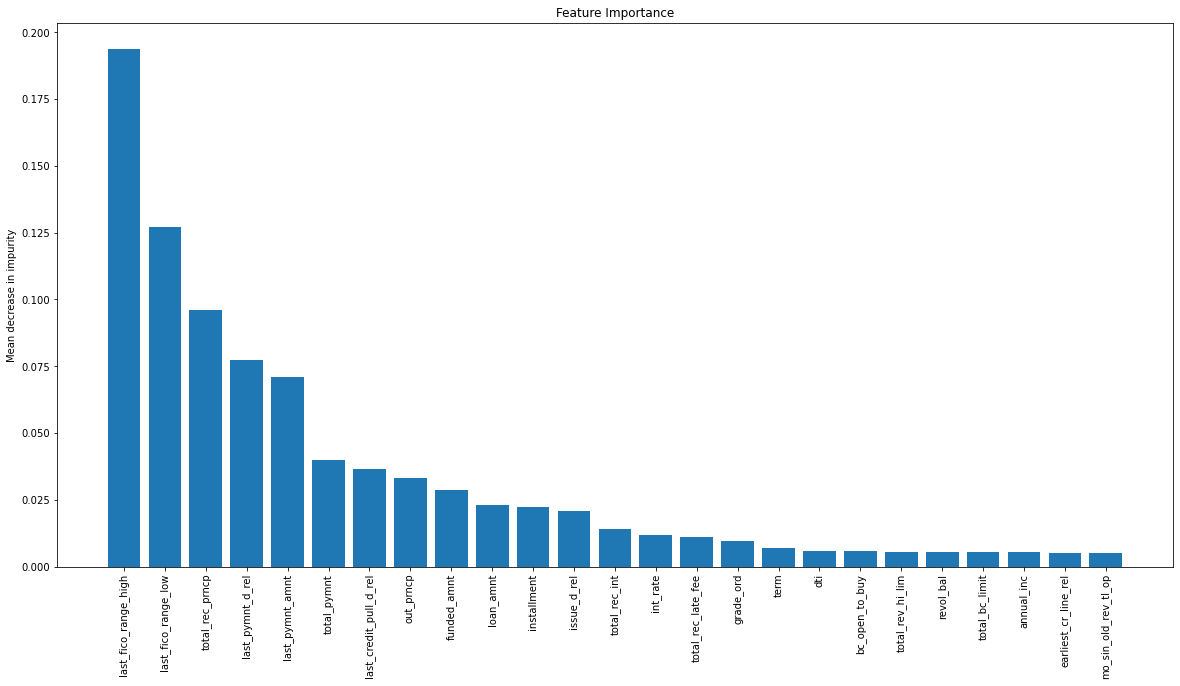

In [35]:
plt.figure(figsize=(20,10))
plt.bar(feature_importance.index,feature_importance.values)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.ylabel('Mean decrease in impurity')
plt.show()

In [36]:
eli5.explain_weights(grid_result.best_estimator_['model'], top=feat_count, feature_names = features)

Weight,Feature
0.1939 ± 0.2578,last_fico_range_high
0.1273 ± 0.2362,last_fico_range_low
0.0961 ± 0.1131,total_rec_prncp
0.0774 ± 0.1036,last_pymnt_d_rel
0.0712 ± 0.0819,last_pymnt_amnt
0.0399 ± 0.0550,total_pymnt
0.0366 ± 0.0941,last_credit_pull_d_rel
0.0333 ± 0.0843,out_prncp
0.0285 ± 0.0543,funded_amnt
0.0230 ± 0.0372,loan_amnt


In [37]:
pd.set_option('display.max_colwidth', None)
definitions = pd.read_csv('LoanStats.csv')

In [38]:
for i in feature_importance.index:
    print(definitions[definitions['LoanStatNew'] == i]['Description'])
    print()

37    The upper boundary range the borrower’s last FICO pulled belongs to.
Name: Description, dtype: object

38    The lower boundary range the borrower’s last FICO pulled belongs to.
Name: Description, dtype: object

109    Principal received to date
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

39    Last total payment amount received
Name: Description, dtype: object

105    Payments received to date for total amount funded
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

80    Remaining outstanding principal for total amount funded
Name: Description, dtype: object

23    The total amount committed to that loan at that point in time.
Name: Description, dtype: object

41    The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
Name: Description, dtype: object

33    The monthly payment owed by the borrow

In [39]:
#Plot Correlation of the most important features

## Feature Importance (Tuned Model)

In [40]:
feature_import_tune = grid_result_tune.best_estimator_._final_estimator.feature_importances_

In [41]:
grid_result_tune.best_estimator_._final_estimator.feature_importances_

array([9.58690024e-19, 4.03256273e-05, 1.01107930e-04, 5.41676392e-05,
       8.40131682e-05, 6.56929725e-05, 4.67311212e-05, 3.94281440e-04,
       4.23040364e-04, 3.90651946e-05, 3.94575072e-05, 5.12141382e-05,
       4.17817427e-05, 4.25301704e-04, 5.30856816e-04, 1.94431657e-05,
       2.78175473e-05, 1.64665891e-02, 2.27995353e-02, 2.87339979e-04,
       1.94107029e-03, 1.09692671e-02, 3.97833977e-04, 1.00457862e-03,
       1.34531634e-03, 4.04327775e-04, 0.00000000e+00, 0.00000000e+00,
       2.73869541e-04, 3.74895192e-04, 9.72353896e-05, 6.97303468e-04,
       1.07931394e-03, 8.42205150e-04, 8.77510752e-03, 2.33528397e-03,
       5.98398417e-02, 1.90720425e-03, 2.03974724e-02, 1.00592130e-01,
       6.26342686e-01, 1.11655040e-02, 1.16217069e-04, 2.23802840e-05,
       3.95003949e-04, 5.66085876e-04, 5.85494033e-04, 3.34916837e-04,
       7.02607373e-04, 9.55085964e-04, 6.97472601e-04, 7.73681296e-05,
       1.09332860e-05, 9.10798218e-04, 1.49470722e-03, 5.69334084e-04,
      

In [42]:
#Get feature names
feat_fit_tune = pipe_tune.fit(X_train, y_train)
onehot_cat_cols_tune = feat_fit_tune.named_steps['preprocess'].transformers_[0][1].named_steps['onehot'].get_feature_names(cat_ix)

onehot_cat_cols_tune = list(onehot_cat_cols_tune)

features_tune = list(onehot_cat_cols_tune)
features_tune.extend(num_ix)

/Users/cxa013/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [44]:
feature_importance_tune = pd.Series(index=features_tune, data=feature_import_tune).nlargest(feat_count)
feature_importance_tune

last_fico_range_high          0.626343
last_pymnt_amnt               0.100592
last_pymnt_d_rel              0.077380
total_rec_prncp               0.059840
funded_amnt                   0.022800
total_rec_late_fee            0.020397
loan_amnt                     0.016467
last_fico_range_low           0.011166
installment                   0.010969
out_prncp                     0.008775
last_credit_pull_d_rel        0.003507
total_pymnt                   0.002335
int_rate                      0.001941
total_rec_int                 0.001907
issue_d_rel                   0.001896
mo_sin_old_rev_tl_op          0.001495
dti                           0.001345
total_il_high_credit_limit    0.001158
mths_since_recent_bc          0.001130
revol_util                    0.001079
annual_inc                    0.001005
num_il_tl                     0.000991
total_bc_limit                0.000982
bc_open_to_buy                0.000955
mo_sin_old_il_acct            0.000911
dtype: float64

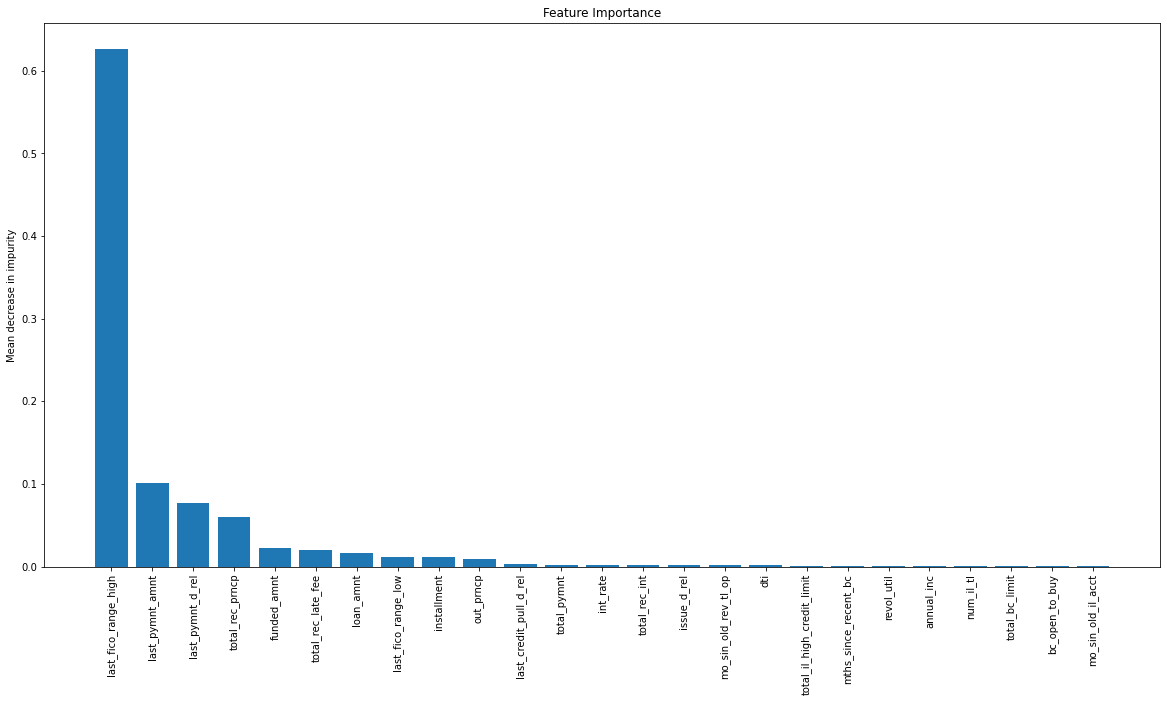

In [45]:
plt.figure(figsize=(20,10))
plt.bar(feature_importance_tune.index,feature_importance_tune.values)
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.ylabel('Mean decrease in impurity')
plt.show()

In [46]:
eli5.explain_weights(grid_result_tune.best_estimator_['model_tune'], top=feat_count, feature_names = features_tune)

Weight,Feature
0.6263 ± 0.0232,last_fico_range_high
0.1006 ± 0.0123,last_pymnt_amnt
0.0774 ± 0.0099,last_pymnt_d_rel
0.0598 ± 0.0128,total_rec_prncp
0.0228 ± 0.0190,funded_amnt
0.0204 ± 0.0058,total_rec_late_fee
0.0165 ± 0.0154,loan_amnt
0.0112 ± 0.0185,last_fico_range_low
0.0110 ± 0.0126,installment
0.0088 ± 0.0077,out_prncp


In [47]:
for i in feature_importance_tune.index:
    print(definitions[definitions['LoanStatNew'] == i]['Description'])
    print()

37    The upper boundary range the borrower’s last FICO pulled belongs to.
Name: Description, dtype: object

39    Last total payment amount received
Name: Description, dtype: object

Series([], Name: Description, dtype: object)

109    Principal received to date
Name: Description, dtype: object

23    The total amount committed to that loan at that point in time.
Name: Description, dtype: object

108    Late fees received to date
Name: Description, dtype: object

41    The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
Name: Description, dtype: object

38    The lower boundary range the borrower’s last FICO pulled belongs to.
Name: Description, dtype: object

33    The monthly payment owed by the borrower if the loan originates.
Name: Description, dtype: object

80    Remaining outstanding principal for total amount funded
Name: Description, dtype: object

Series([

In [48]:
#Plot Correlation of the most important features

## Save Model

### Pickle

In [64]:
import pickle

filename = 'trained_rf_v2.sav'

pickle.dump(grid_result_tune, open(filename, 'wb'))

In [56]:
#RandomForestClassifier(class_weight='balanced_subsample', max_features=None, n_estimators=250)

grid_result_tune.best_estimator_._final_estimator

RandomForestClassifier(class_weight='balanced_subsample', max_features=None,
                       n_estimators=250)

In [65]:
loaded_model = pickle.load(open(filename, 'rb'))

In [66]:
loaded_model.score(X_test, y_test)

0.9555888223552895

In [75]:
pd.Series(loaded_model.predict(X_test)).to_frame().value_counts()

0    10952
1     1548
dtype: int64

In [76]:
confusion_matrix(y_test, loaded_model.predict(X_test))

array([[10867,    16],
       [   85,  1532]])

### Joblib

In [ ]:
joblib.dump(grid_tune, 'joblib_trained_rf.pkl')

In [68]:
jl_loaded_model = joblib.load('joblib_trained_rf.pkl')

In [69]:
jl_loaded_model.score(X_test, y_test)

0.9555888223552895

# END